In [1]:
import SimpleITK as sitk
import nibabel as nib
import time
import numpy as np
import glob
import os
from tqdm import tqdm

def register_im(im_fixed, im_moving, param_map=None, verbose=True, im_fixed_spacing=None,
im_moving_spacing=None, max_iter=200, return_params=True, non_rigid=False, fixed_mask=None,
moving_mask=None, ref_fixed=None, ref_moving=None):
    '''
    Image registration using SimpleElastix.
    Register im_moving to im_fixed
    '''

    default_transform = 'translation'

    sim0 = sitk.GetImageFromArray(im_fixed)
    sim1 = sitk.GetImageFromArray(im_moving)

    if im_fixed_spacing is not None:
        sim0.SetSpacing(im_fixed_spacing)

    if im_moving_spacing is not None:
        sim1.SetSpacing(im_moving_spacing)

    if ref_fixed is not None:
        sim0.CopyInformation(ref_fixed)

    if ref_moving is not None:
        sim1.CopyInformation(ref_moving)

    if param_map is None:
        if verbose:
            print("using default '{}' parameter map".format(default_transform))
        param_map = sitk.GetDefaultParameterMap(default_transform)

    if non_rigid:
        param_map = sitk.VectorOfParameterMap()
        param_map.append(sitk.GetDefaultParameterMap('affine'))
        param_map.append(sitk.GetDefaultParameterMap('bspline'))

    param_map['MaximumNumberOfIterations'] = [str(max_iter)]

    ef = sitk.ElastixImageFilter()
    ef.SetLogToConsole(True)
    ef.SetFixedImage(sim0)
    ef.SetMovingImage(sim1)

    if fixed_mask is not None:
        fmask = sitk.GetImageFromArray(fixed_mask.astype(np.uint8))
        fmask.SetSpacing(im_fixed_spacing)
        ef.SetFixedMask(fmask)

    if moving_mask is not None:
        mmask = sitk.GetImageFromArray(moving_mask.astype(np.uint8))
        mmask.SetSpacing(im_moving_spacing)
        ef.SetMovingMask(mmask)

    ef.SetParameterMap(param_map)

    if verbose:
        print('image registration')
        tic = time.time()

    # TODO: Set mask for registration by using ef.SetFixedMask(brain_mask)
    ef.Execute()

    if verbose:
        toc = time.time()
        print('registration done, {:.3} s'.format(toc - tic))

    sim_out = ef.GetResultImage()
    param_map_out = ef.GetTransformParameterMap()

    im_out = sitk.GetArrayFromImage(sim_out)
    im_out = np.clip(im_out, 0, im_out.max())

    if not return_params:
        return im_out, sim_out

    return im_out, sim_out, param_map_out

In [2]:
t1_file = '../../data/IXI/IXI_dataset/IXI036-Guys-0736/IXI036-Guys-0736-T1.nii.gz'
t2_file = '../../data/IXI/IXI_dataset/IXI036-Guys-0736/IXI036-Guys-0736-T2.nii.gz'
pd_file = '../../data/IXI/IXI_dataset/IXI036-Guys-0736/IXI036-Guys-0736-PD.nii.gz'
    
t1_image = sitk.ReadImage(t1_file)
t2_image = sitk.ReadImage(t2_file)
pd_image = sitk.ReadImage(pd_file)
_, t1_r_img, _ = register_im(sitk.GetArrayFromImage(t2_image), sitk.GetArrayFromImage(t1_image), ref_fixed=t2_image, ref_moving=t1_image, param_map=sitk.GetDefaultParameterMap('affine'), verbose=False)
_, pd_r_img, _ = register_im(sitk.GetArrayFromImage(t2_image), sitk.GetArrayFromImage(pd_image), ref_fixed=t2_image, ref_moving=pd_image, param_map=sitk.GetDefaultParameterMap('affine'), verbose=False)

t1_fn = 'test_t1.nii.gz'
t2_fn = 'test_t2.nii.gz'
pd_fn = 'test_pd.nii.gz'
sitk.WriteImage(t1_r_img, t1_fn)
sitk.WriteImage(t2_image, t2_fn)
sitk.WriteImage(pd_r_img, pd_fn)

Installing all components.
InstallingComponents was successful.

ELASTIX version: 4.900
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
InitializeTransform took 0.00s
  The default value "false" is used instead.
Scales for transform parameters are: [100000, 100000, 100000, 100000, 100000, 100000, 1000

45	-1.029666	5.785380	12.282097	0.007730	12.9
46	-1.025550	5.738296	12.303725	0.010321	12.4
47	-1.014951	6.736693	11.860846	0.008352	63.4
48	-1.032608	7.337383	11.609422	0.006233	32.6
49	-1.020296	7.290284	11.628750	0.009274	27.6
50	-1.015744	7.243190	11.648140	0.013224	14.4
51	-1.009044	7.196091	11.667597	0.005834	16.8
52	-1.032114	7.148992	11.687119	0.007190	14.4
53	-1.040873	7.102318	11.706530	0.011465	14.9
54	-1.045986	7.055219	11.726183	0.009082	14.3
55	-1.023814	7.032905	11.735517	0.006886	12.3
56	-1.032432	6.985806	11.755268	0.004573	12.0
57	-1.048184	6.938708	11.775084	0.012115	14.8
58	-1.042109	7.727663	11.451702	0.011330	17.1
59	-1.013346	7.680564	11.470508	0.005744	11.6
60	-1.035529	7.633477	11.489371	0.005843	12.4
61	-1.038032	7.586379	11.508301	0.009660	11.9
62	-1.004812	7.631755	11.490062	0.010504	24.8
63	-1.046603	7.584656	11.508994	0.009523	14.0
64	-1.041111	8.584656	11.119975	0.006266	13.5
65	-1.060488	8.537566	11.137703	0.010232	14.6
66	-1.002685	8.490468	11.155491	0.

Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.003285s
  NumberOfGradientMeasurements to estimate sigma_i: 9
  Sampling gradients ...
  Sampling the gradients took 0.255138s
Automatic parameter estimation took 0.35s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.854738	0.000000	19.948146	0.008953	578.5
1	-0.863568	0.000000	19.948146	0.006474	19.5
2	-0.864306	0.000000	19.948146	0.010996	17.1
3	-0.881269	0.401975	19.573477	0.007846	14.8
4	-0.865299	0.000000	19.948146	0.012574	12.7
5	-0.869525	0.266086	19.698551	0.010544	14.6
6	-0.876361	1.263809	18.815786	0.012683	11.5
7	-0.856444	0.737833	19.271059	0.009687	13.0
8	-0.872713	0.211684	19.749071	0.006395	9.8
9	-0.870060	1.093069	18.961198	0.008324	14.2
10	-0.873848	0.649289	19.349876	0.010736	10.4
11	-0.874440	1.606907	18.530224	0.008892	13.6
12	-0.838775	2.598796	17.751375

178	-0.868894	52.170815	5.725111	0.010372	13.0
179	-0.861035	51.657865	5.765529	0.008696	11.8
180	-0.874240	51.134794	5.807337	0.012625	13.4
181	-0.896907	50.609615	5.849928	0.009580	12.2
182	-0.874177	51.601877	5.769976	0.005591	9.0
183	-0.890884	51.251864	5.797927	0.015420	13.3
184	-0.901208	52.244057	5.719386	0.014160	8.5
185	-0.849405	53.243372	5.642404	0.014130	11.4
186	-0.864954	54.234095	5.568101	0.006288	24.0
187	-0.855150	55.012662	5.511069	0.016559	17.9
188	-0.880854	55.625192	5.467015	0.005737	14.5
189	-0.885570	55.131949	5.502435	0.012744	19.1
190	-0.896055	54.614873	5.540062	0.019309	12.3
191	-0.891617	55.610862	5.468037	0.010419	22.1
192	-0.876819	56.610862	5.397583	0.006502	18.6
193	-0.863170	56.098427	5.433458	0.010898	23.7
194	-0.845094	55.677670	5.463273	0.008255	14.5
195	-0.877253	56.626360	5.396505	0.008388	22.2
196	-0.893511	57.443926	5.340261	0.005859	31.1
197	-0.898154	56.942514	5.374616	0.009507	32.5
198	-0.868149	56.442236	5.409336	0.018693	21.0
199	-0.871397	5

59	-0.778582	20.502389	10.389496	0.006739	37.6
60	-0.801793	21.093076	10.243701	0.016653	28.5
61	-0.795961	22.088488	10.007056	0.018942	34.3
62	-0.805254	23.087933	9.780202	0.009813	20.3
63	-0.791874	22.678810	9.871810	0.010206	16.8
64	-0.809838	22.271136	9.964816	0.011294	10.3
65	-0.785794	21.910215	10.048631	0.010478	9.4
66	-0.793363	21.502314	10.145069	0.010769	12.9
67	-0.800663	21.094528	10.243348	0.015636	10.7
68	-0.790811	20.684700	10.344057	0.023679	12.5
69	-0.764671	21.684700	10.101720	0.011152	11.9
70	-0.776760	22.684700	9.870479	0.012138	11.7
71	-0.802455	23.683882	9.649764	0.017422	12.2
72	-0.813549	24.683856	9.438540	0.005667	11.9
73	-0.802766	25.634807	9.246074	0.008472	12.0
74	-0.790959	25.271735	9.318624	0.012754	12.0
75	-0.807440	26.216287	9.132207	0.014440	8.9
76	-0.801418	26.351598	9.106111	0.009411	14.1
77	-0.783220	25.941976	9.185572	0.019843	13.0
78	-0.803863	25.532230	9.266457	0.012950	12.1
79	-0.771822	26.323334	9.111550	0.011763	10.6
80	-0.770800	27.322619	8.923

  Computing the moving image extrema took 73 ms.
Initialization of AdvancedMattesMutualInformation metric took: 181 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.003353s
  NumberOfGradientMeasurements to estimate sigma_i: 9
  Sampling gradients ...
  Sampling the gradients took 0.460338s
Automatic parameter estimation took 0.55s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.728828	0.000000	15.674621	0.021825	833.1
1	-0.728460	0.000000	15.674621	0.017574	9.2
2	-0.722006	0.000000	15.674621	0.022149	10.8
3	-0.720617	0.000000	15.674621	0.048205	9.2
4	-0.725715	1.000000	14.962138	0.010927	31.6
5	-0.728147	2.000000	14.311611	0.020753	15.1
6	-0.753615	1.583352	14.575651	0.013545	12.9
7	-0.744721	2.470674	14.024610	0.017319	11.8
8	-0.744135	3.430897	13.473392	0.025628	8.3
9	-0.739563	4.430894	12.943589	0.024580	11.9
10	-0

167	-0.762671	48.974239	4.704118	0.007876	41.9
168	-0.749130	48.646226	4.726273	0.024432	31.5
169	-0.760816	49.625855	4.660716	0.017548	12.7
170	-0.758767	50.625676	4.595657	0.012737	32.1
171	-0.730846	51.625160	4.532411	0.035850	40.0
172	-0.748685	52.625160	4.470850	0.021237	31.7
173	-0.738364	53.625160	4.410939	0.032866	36.1
174	-0.749925	53.208503	4.435705	0.022857	36.1
175	-0.752447	54.208503	4.376726	0.011855	53.3
176	-0.746596	53.791854	4.401108	0.012340	55.3
177	-0.757528	53.796807	4.400817	0.030615	26.8
178	-0.758431	54.795202	4.342848	0.012305	11.2
179	-0.744257	55.759927	4.288267	0.014784	8.2
180	-0.761117	55.348405	4.311381	0.013659	8.2
181	-0.766729	56.346259	4.255759	0.026083	8.0
182	-0.741713	57.346208	4.201442	0.014885	12.2
183	-0.762693	58.346186	4.148492	0.022878	8.5
184	-0.763652	58.309124	4.150431	0.011416	7.9
185	-0.728624	58.170640	4.157691	0.020041	8.1
186	-0.765243	57.754754	4.179647	0.020174	8.4
187	-0.743989	58.754752	4.127241	0.017638	11.0
188	-0.733978	59.194

  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001640s
  NumberOfGradientMeasurements to estimate sigma_i: 9
  Sampling gradients ...
  Sampling the gradients took 0.218038s
Automatic parameter estimation took 0.29s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-1.052434	0.000000	30.892014	0.006975	460.1
1	-1.117107	0.000000	30.892014	0.012139	12.5
2	-1.110265	0.996646	29.492328	0.012860	12.0
3	-1.133152	1.996646	28.209866	0.005028	8.3
4	-1.125951	2.996455	27.034506	0.012235	12.8
5	-1.098393	2.836123	27.216351	0.009088	9.1
6	-1.115315	3.835842	26.120810	0.008145	8.3
7	-1.109867	3.675509	26.290533	0.008193	10.8
8	-1.113809	4.190908	25.752636	0.006621	8.4
9	-1.136315	4.030576	25.917594	0.009143	15.7
10	-1.116379	3.938537	26.013246	0.006993	15.7
11	-1.132006	3.887663	26.066420	0.008628	14.7
12	-1.116763	3.727331	26.235435	0.012063	9.3
13	-1.128718	4.727329	25.215687	0.010565	9.1
14	-1.103266	5.726520	24.2

177	-1.104603	70.877761	7.060820	0.003614	11.1
178	-1.126586	70.730544	7.072151	0.008105	10.5
179	-1.135082	70.968458	7.053856	0.005422	17.1
180	-1.140012	71.967985	6.978018	0.009102	17.2
181	-1.098839	71.807655	6.990073	0.011028	12.2
182	-1.141842	72.807655	6.915558	0.007583	11.7
183	-1.104454	73.785599	6.844207	0.004344	15.2
184	-1.119382	73.627182	6.855665	0.005233	11.6
185	-1.116448	73.666125	6.852845	0.006997	12.7
186	-1.171277	74.648796	6.782441	0.004644	8.6
187	-1.183107	74.488497	6.793827	0.007413	10.8
188	-1.127179	74.331282	6.805031	0.009005	8.7
189	-1.111017	75.293315	6.737044	0.009387	9.9
190	-1.141650	75.132983	6.748280	0.007114	13.5
191	-1.118644	76.132979	6.678806	0.003230	15.2
192	-1.081206	75.986633	6.688884	0.002962	22.2
193	-1.132912	75.895091	6.695203	0.006760	11.3
194	-1.116347	75.750126	6.705235	0.005783	11.8
195	-1.142382	76.748591	6.636743	0.008968	10.4
196	-1.105463	76.599107	6.646908	0.009885	8.2
197	-1.156649	77.598838	6.579513	0.007998	9.3
198	-1.120412	78.5

56	-1.007620	29.823371	7.917582	0.007350	10.8
57	-0.956855	29.788485	7.923021	0.008307	13.3
58	-1.002403	29.836786	7.915493	0.009158	10.7
59	-0.991873	29.732933	7.931697	0.007673	12.9
60	-0.998278	29.512862	7.966253	0.009834	12.0
61	-1.039314	29.548439	7.960646	0.016229	9.0
62	-1.023628	30.548438	7.806216	0.007344	15.3
63	-1.010132	30.327240	7.839857	0.003924	15.9
64	-0.995854	30.126961	7.870568	0.010899	11.9
65	-1.015091	30.889874	7.754851	0.012712	12.0
66	-0.996548	31.889544	7.608276	0.013696	16.0
67	-1.027882	32.889526	7.467095	0.011316	19.9
68	-0.985721	33.878555	7.332522	0.011264	12.9
69	-0.971582	33.659093	7.361963	0.013549	9.6
70	-1.013635	34.608342	7.236293	0.010846	9.2
71	-0.995762	35.608181	7.108482	0.008527	9.0
72	-0.986110	35.384676	7.136659	0.005320	8.1
73	-0.979301	35.164964	7.164577	0.008056	11.1
74	-0.975354	35.969631	7.063381	0.006626	11.2
75	-0.997508	36.919313	6.947566	0.007002	7.5
76	-1.012101	37.842682	6.838543	0.014055	13.4
77	-0.995303	38.842459	6.724293	0.011556

  The default value "0" is used instead.
  The default value "192" is used instead.
  The default value "10" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "1" is used instead.
  The default value "0.9375" is used instead.
  The default value "0" is used instead.
  The default value "1000" is used instead.
  The default value "0.1" is used instead.
Elastix initialization of all components (for this resolution) took: 56 ms.
  Computing the fixed image extrema took 25 ms.
  Computing the moving image extrema took 4 ms.
Initialization of AdvancedMattesMutualInformation metric took: 99 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001622s
  NumberOfGradientMeasurements to estimate sigma_i: 9
  Sampling gradients ...
  Sampling the gradients took 0.168051s
Aut

138	-0.964713	65.934589	3.735449	0.011559	25.0
139	-0.932634	66.404622	3.715361	0.007727	32.0
140	-0.928912	67.014100	3.689633	0.010670	10.9
141	-0.930321	66.830195	3.697358	0.017064	8.8
142	-0.932832	67.829842	3.655750	0.033286	10.8
143	-0.964298	68.829842	3.615054	0.017683	16.8
144	-0.909368	68.626975	3.623236	0.004825	12.6
145	-0.935198	68.484259	3.629015	0.019457	16.8
146	-0.954722	69.279040	3.597067	0.013107	23.2
147	-0.903261	70.279037	3.557659	0.013647	11.7
148	-0.963407	70.081885	3.565360	0.022877	11.0
149	-0.935478	71.081866	3.526641	0.007029	11.0
150	-0.931603	72.081833	3.488755	0.018449	12.4
151	-0.976775	71.978738	3.492623	0.021572	9.1
152	-0.958446	72.414519	3.476330	0.015893	14.2
153	-0.928424	73.414519	3.439510	0.006935	11.7
154	-0.950623	73.407851	3.439753	0.010992	11.6
155	-0.936300	74.364092	3.405262	0.008558	10.9
156	-0.953641	74.271324	3.408578	0.012389	20.1
157	-0.947368	75.193375	3.375905	0.010686	8.7
158	-0.942224	74.990649	3.383035	0.025972	13.6
159	-0.947138	74

13	-0.918585	7.691960	4.808658	0.018465	14.6
14	-0.923484	8.689734	4.647055	0.015940	17.8
15	-0.926821	8.579615	4.664355	0.032230	11.3
16	-0.898388	9.575418	4.512443	0.036602	8.8
17	-0.894404	10.575418	4.369533	0.011178	8.8
18	-0.899564	10.722987	4.349206	0.025884	10.9
19	-0.908600	11.270539	4.275411	0.013635	10.0
20	-0.918423	11.290536	4.272763	0.042074	14.9
21	-0.895361	12.218827	4.153362	0.032912	8.5
22	-0.876196	13.218827	4.031986	0.014749	11.0
23	-0.916383	14.205976	3.918932	0.013408	19.6
24	-0.914426	14.626243	3.872702	0.034505	8.6
25	-0.904844	15.611252	3.768509	0.014265	8.5
26	-0.902153	16.611041	3.668333	0.036557	9.9
27	-0.913338	16.604799	3.668942	0.024164	9.9
28	-0.902003	17.604796	3.573904	0.017137	9.4
29	-0.889936	17.674648	3.567449	0.024949	11.5
30	-0.898681	17.565096	3.577583	0.032753	10.2
31	-0.903409	18.564963	3.487172	0.016820	8.7
32	-0.880388	19.564928	3.401210	0.011869	8.1
33	-0.875921	19.834961	3.378718	0.024503	13.3
34	-0.895360	20.479295	3.326234	0.031542	15.6
35

192	-0.891409	79.903650	1.367342	0.021648	22.3
193	-0.935755	80.569314	1.358381	0.016942	21.4
194	-0.896479	80.460255	1.359841	0.018350	10.5
195	-0.939689	81.305644	1.348604	0.016320	13.6
196	-0.869535	81.195786	1.350054	0.036651	11.9
197	-0.907946	82.195780	1.336972	0.017961	12.0
198	-0.884831	82.085156	1.338406	0.021072	10.4
199	-0.890436	82.671141	1.330841	0.026393	10.8
Time spent in resolution 3 (ITK initialization and iterating): 3.606 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 3:
( SP_a 137.969822 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.110625 )
( SigmoidScale 0.000037 )



Creating the TransformParameterFile took 0.00s

Registration result checksum: 3067474760

Final metric value  = -0.890436
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 648.732295 402.398234 324.739711 137.969822 )
( SP_A 20.000000 20.000000 20.000000 20.0

In [4]:
t1_a = sitk.GetArrayFromImage(t1_r_img) 
t2_a = sitk.GetArrayFromImage(t2_image)
pd_a = sitk.GetArrayFromImage(pd_r_img)

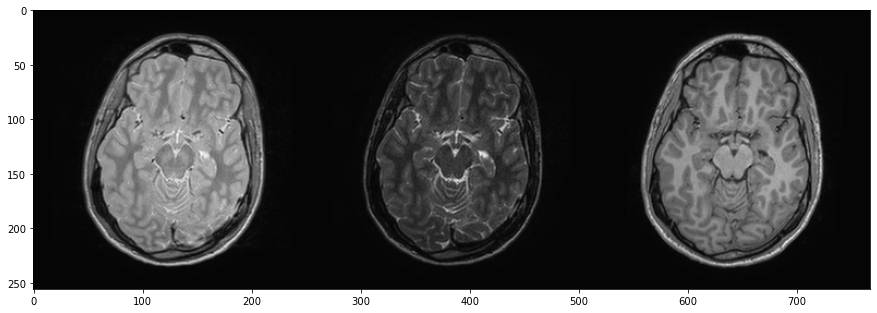

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.imshow(np.rot90(np.concatenate([t1_a[46, :, :], t2_a[46, :, :], pd_a[46, :, :]], axis=1), k=2), cmap='gray')

In [20]:
slice = np.rot90(np.stack([t1_a[65, :, :], t2_a[65, :, :], pd_a[65, :, :]], axis=2), k=2)
print(slice.shape)

(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


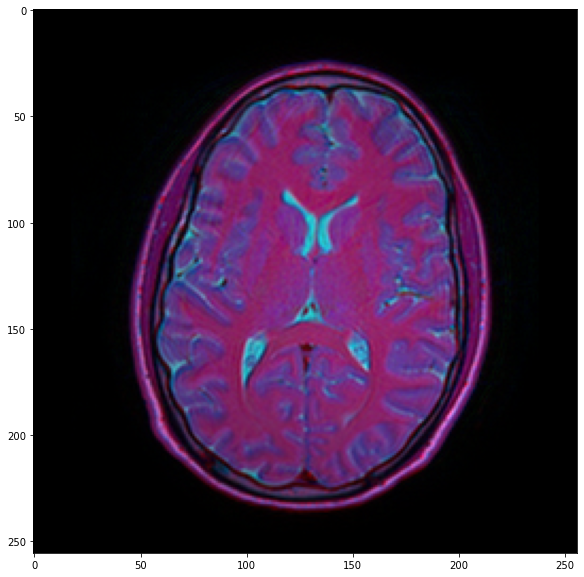

In [21]:
slice = slice/slice.max()
plt.imshow(slice, cmap='gray')

In [22]:
t1_a = sitk.GetArrayFromImage(sitk.ReadImage("../../data/IXI/IXI_dataset_coregistered/IXI035-IOP-0873/IXI035-IOP-0873-T1.nii.gz")) 
t2_a = sitk.GetArrayFromImage(sitk.ReadImage("../../data/IXI/IXI_dataset_coregistered/IXI035-IOP-0873/IXI035-IOP-0873-T2.nii.gz")) 
pd_a = sitk.GetArrayFromImage(sitk.ReadImage("../../data/IXI/IXI_dataset_coregistered/IXI035-IOP-0873/IXI035-IOP-0873-PD.nii.gz")) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


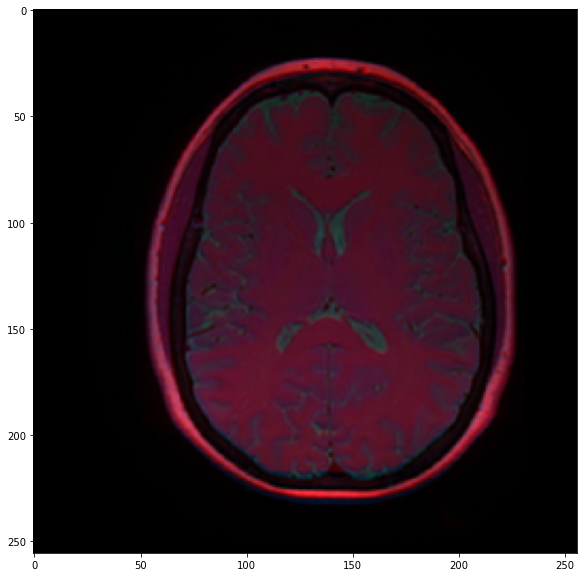

In [24]:
slice = np.rot90(np.stack([t1_a[75, :, :], t2_a[75, :, :], pd_a[75, :, :]], axis=2), k=2)
slice = slice/slice.max()
plt.imshow(slice, cmap='gray')